# 4. Intro. Net and Optim API


In this tutorial, we implement neural network and optimization in object oriented fashion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from torch import nn
from torch.autograd import Variable
from abc import ABC, abstractmethod

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
class Gate(ABC):
    def __init__(self):
        self.num_param=0           
        self.weight, self.bias=None, None
        self.dweight, self.dbias=None, None
    @abstractmethod
    def forward(self, *args, **kwargs):
        pass
    @abstractmethod
    def backward(self, *args, **kwargs):
        pass
    @property
    def param_size(self):
        if self.weight is None and self.bias is None:
            return 0
        return self.weight.size+self.bias.size   
    def dim_checker(self,a,b):
        return a.shape==b.shape

In [3]:
class Conv(Gate):
    def __init__(self,in_channels=1, out_channels=1,kernel_size=(2, 2), stride=1, padding=0):        
        super().__init__()
        self.kernel_h,self.kernel_w=kernel_size
        self.weight=np.random.randn(out_channels,
                               in_channels,
                               self.kernel_h,
                               self.kernel_w) /np.sqrt(in_channels/2)
        self.bias=np.zeros(out_channels)    
        self.stride=stride
        self.padding=padding
        self.cache=dict()

    def set_params(self,weights,bias=None):
        self.weight,self.bias=weights, bias
        n,d,self.kernel_h,self.kernel_w=self.weight.shape        

    def compute_dim(self,X):
        # parameter check
        xN, xD, xH, xW = X.shape
        wN, wD, wH, wW = self.weight.shape
        assert wH == wW
        assert (xH - wH) % self.stride == 0
        assert (xW - wW) % self.stride == 0
        self.cache['X']=X
        
        zH, zW = (xH - wH) // self.stride + 1, (xW - wW) // self.stride + 1
        zD,zN = wN,xN
        return np.zeros((zN, zD, zH, zW))
    
    def get_region(self,hight,width):
        h1=hight*self.stride
        h2=h1+self.kernel_h
        w1=width*self.stride
        w2=w1+self.kernel_w
        return h1,h2,w1,w2
    
    def convolve_forward_step(self,X_n):
        xD, xH, xW = X_n.shape
        hZ=int((xH-self.kernel_h)/self.stride+1)
        wZ=int((xW-self.kernel_w)/self.stride+1)
        Z = np.zeros((len(self.weight),hZ, wZ))
        
        for d in range(len(Z)):
            for i in range(hZ):
                for j in range(wZ):
                    h1,h2,w1,w2=self.get_region(i,j)
                    x_loc = X_n[:, 
                              h1: h2,
                              w1: w2]
                    Z[d,i,j]=np.sum(x_loc*self.weight[d])+ self.bias[d]
        return Z
    
    def forward(self,X):
        Z=self.compute_dim(X)
        for n in range(len(Z)):
            Z[n,:,:,:]=self.convolve_forward_step(X[n])
        self.cache['Z']=Z
        return Z
    
    def backward(self,dZ):        
        assert self.dim_checker(dZ,self.cache['Z'])
        
        dX, self.dweight, self.dbias=np.zeros(self.cache['X'].shape), np.zeros(self.weight.shape),np.zeros(self.bias.shape)
        (N, depth, hight, width) = dZ.shape
         
        for n in range(N):
            for h in range(hight):        
                for w in range(width):      
                    for d in range(depth): # correcponds to d.th kernel
                        h1,h2,w1,w2=self.get_region(h,w)
                        dX[n,:,h1:h2,w1:w2]+= self.weight[d,:,:,:] * dZ[n, d, h, w]
                        self.dweight[d,:,:,:] += self.cache['X'][n, :, h1:h2, w1:w2] * dZ[n, d, h, w]            
                        self.dbias[d] +=dZ[n, d, h, w]
                    
        return dX

In [4]:
class Reshape(Gate):
    def __init__(self,out_shape=None,flatten=False):
        super().__init__()
        self.flatten=flatten
        self.out_shape=out_shape     
        self.cache=dict()
    def forward(self, X):
        self.cache['X']=X
        if self.flatten==True:
            self.out_shape=(len(X), X.size//len(X))
        Z= np.reshape(X,self.out_shape)       
        return Z
    def backward(self, dL_dZ):
        dX= dL_dZ.reshape(self.cache['X'].shape)        
        return dX

In [5]:
class Softmax(Gate):
    def __init__(self):
        super().__init__()

    def forward(self, X,axis=1):
        assert len(X.shape)==2
        X-=np.max(X,axis=axis,keepdims=True)
        exp_scores=np.exp(X)
        Z=exp_scores/np.sum(exp_scores,axis=axis,keepdims=True)
        return Z
    def backward(self, dL_dZ):
        return dL_dZ

In [6]:
class Linear(Gate):
    def __init__(self,in_features, out_features):
        super().__init__()
        self.weight=np.random.rand(in_features,out_features)/in_features
        self.bias=np.random.rand(out_features)
        self.cache=dict()
    def forward(self, X):
        """
        Parameters
        ----------
        X : shape=(N,in_features)
        
        Returns
        ----------
        Z:shape(N,out_features)
        """
        self.cache['X']=X
        Z=X.dot(self.weight)+self.bias
        return Z
    
    def backward(self, dZ):
        """
        Parameters
        ----------
        dZ : shape=(N,out_features)
        
        ----------
        dX: dZ (N,out_features) * weight (out_features,in_features) => (N,in_features)

        dW: X.T (in_features,N,) * dZ (N,out_features) => (in_features,out_features)
        
        db: dZ= (out_features,)

        Returns
        -------
        dX : shape (N,in_features)
        """
        dX= dZ.dot(self.weight.T) # dL/dZ * dZ/dX
        self.dweight= self.cache['X'].T.dot(dZ)        # dZ/dX* dL/dZ
        self.dbias=dZ.sum(axis=0)
        try:
            assert self.dweight.shape==self.weight.shape
            assert self.dbias.shape==self.bias.shape
        except AssertionError as a:
            print(self.weight.shape)
            print(self.dweight.shape)

            print(self.bias.shape)
            print(self.dbias.shape)
            
            raise
        return dX

(1797, 8, 8)
(1797, 1, 8, 8) (1797,)


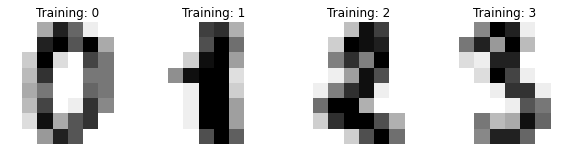

In [7]:
# Digit Recognition
digits = datasets.load_digits()
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)
    X=digits.images
y=digits.target
#Descritive stats; distribution of labels.
#print(np.histogram(y, density=True))
print(X.shape)

X_images=np.expand_dims(X, axis=1)
print(X_images.shape, y.shape)

# Optimization

In [8]:
from abc import ABC, abstractmethod
class Optim(ABC):
    def __init__(self,learning_rate=.001):
        self.learning_rate=learning_rate
    @abstractmethod
    def update(self, *args, **kwargs):
        pass

class SGD(Optim):
    def __init__(self,learning_rate=.001):
        super().__init__()
        self.learning_rate=learning_rate
        
    def update(self,gates):
        for g in gates:
            if g.param_size>0:
                try:
                    g.weight += - self.learning_rate * g.dweight
                    g.bias   += - self.learning_rate * g.dbias
                except TypeError as e:
                    print(g)
                    print(g.weight)
                    print(g.bias)
                    print(g.dweight)
                    print(g.dbias)
                    raise 


In [9]:
class Net:
    def __init__(self,optimizer,verbose=0):
        self.gates = []
        self.optimizer=optimizer
        self.losses=[]
        self.verbose=verbose
        self.total_param=0
    
    def describe(self):
        for th, g in enumerate(self.gates):
            print(f'[{th+1}. layer] => {g}')  
        print(f'Total param.:{self.total_param}')

    def add(self, gate):
        self.total_param+=gate.param_size
        self.gates.append(gate)
        
    def add_from_iter(self, l):
        for gate in l:
            self.add(gate)
            if gate.num_param>0:
                self.param_gates.add(gate)

    def forward(self, inputs):
        if len(inputs)==1:
            inputs=np.expand_dims(inputs, axis=0)
        for g in self.gates:
            inputs = g.forward(inputs)
        return inputs

    def backward(self, dL):
        for g in reversed(self.gates):
            dL = g.backward(dL)
    
    def iterate_minibatches(self, inputs, targets, batchsize, shuffle_per_epoch=False):
        assert inputs.shape[0] == targets.shape[0]
        if shuffle_per_epoch:
            indices = np.arange(inputs.shape[0])
            np.random.shuffle(indices)
        for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
            if shuffle_per_epoch:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]

    def train(self,X,y,epoch=100,print_out_per_epoch=1,batchsize=256,shuffle_per_epoch=True):
        
        print('Training starts.')
        for i in range(1, epoch+1):
            loss,acc=0,0
            for X_minibatch, y_minibatch in self.iterate_minibatches(X,y,batchsize,shuffle_per_epoch):

                Z=self.forward(X_minibatch)
                pred_prob_true_class=Z[range(len(Z)),y_minibatch]
                loss += (-np.log(pred_prob_true_class)).sum()            
                acc  += (np.argmax(Z,axis=1)==y_minibatch).sum()

                # Compute Gradients of cross entropy loss w.r.t. predictions.
                dL_dZ = Z
                dL_dZ[range(len(Z)),y_minibatch] -= 1 
                dL_dZ/=len(dL_dZ)

                self.backward(dL_dZ)
                self.optimizer.update(self.gates)    

            avg_acc=acc/len(X)
            avg_loss=loss/len(X)
            
            if i%print_out_per_epoch==0:
                    print(f'[Epoch:{i}]-[Avg.Loss:{avg_loss:.3f}]-[Avg.Acc:{avg_acc:.3f}]')
    

In [10]:
net=Net(optimizer=SGD())
net.add_from_iter([Conv(in_channels=1,out_channels=2,kernel_size=(2,2),stride=1),
                   Reshape(flatten=True),
                   Linear(in_features=98,out_features=10),
                   Softmax()])
net.train(X_images,y,epoch=10,batchsize=len(X_images),shuffle_per_epoch=False) # Full, without shuffle.

Training starts.
[Epoch:1]-[Avg.Loss:3.563]-[Avg.Acc:0.102]
[Epoch:2]-[Avg.Loss:11.021]-[Avg.Acc:0.519]
[Epoch:3]-[Avg.Loss:15.959]-[Avg.Acc:0.191]
[Epoch:4]-[Avg.Loss:22.871]-[Avg.Acc:0.368]
[Epoch:5]-[Avg.Loss:27.121]-[Avg.Acc:0.202]
[Epoch:6]-[Avg.Loss:28.514]-[Avg.Acc:0.350]
[Epoch:7]-[Avg.Loss:25.606]-[Avg.Acc:0.275]
[Epoch:8]-[Avg.Loss:23.514]-[Avg.Acc:0.264]
[Epoch:9]-[Avg.Loss:23.330]-[Avg.Acc:0.348]
[Epoch:10]-[Avg.Loss:22.057]-[Avg.Acc:0.441]


In [ ]:
net=Net(optimizer=SGD())
net.add_from_iter([Conv(in_channels=1,out_channels=2,kernel_size=(2,2),stride=1),
                   Reshape(flatten=True),
                   Linear(in_features=98,out_features=10),
                   Softmax()])
net.train(X_images,y,epoch=10,batchsize=len(X_images)//4,shuffle_per_epoch=True) # minibatch, with shuffle.

Training starts.
[Epoch:1]-[Avg.Loss:2.172]-[Avg.Acc:0.277]
[Epoch:2]-[Avg.Loss:1.262]-[Avg.Acc:0.650]
